In [1]:
!pip install --upgrade jupyter_client
!pip install keras_tuner
from loadfunctions import *
from PIL import Image
import os, sys, glob
import fnmatch
import numpy as np
import tensorflow as tf
import random
import keras_tuner as kt
from IPython.display import clear_output

a=1

198
99
99
/home/jovyan/work/nasa_planet_dataset/1019.jpg


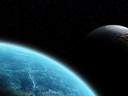

(594, 96, 128, 3)
(96, 128, 3)


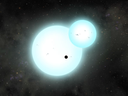

(535, 96, 128, 3) (59, 96, 128, 3)


In [1]:
input_width = 128
input_height = int(input_width*.75)
input_channels = 3

all_images,src_images,resized_images= get_image_lists()   
print(len(all_images))
print(len(src_images))
print(len(resized_images))
print(src_images[0])
np_images_list = resize(src_images,input_width,int(input_width*.75))


np_images_list[0].shape
tf.keras.preprocessing.image.array_to_img(np_images_list[0]).show()


np_images = np.array(np_images_list,dtype='float16',ndmin=(4))
np_images = easy_training_aug(np_images)
np.random.shuffle( np_images)
print(np_images.shape)
print(np_images[0].shape)
tf.keras.preprocessing.image.array_to_img(np_images[0]).show()

test_num = int(len(np_images)*.1)
X = np_images[0:-test_num]
X_test = np_images[-test_num:]

print(X.shape,X_test.shape)

def my_conv2dtrans(in_size,out_size,filters=64):
    ## if Padding == Valid;
    ## HO = (HI-1) * stride + HF
    ## stride = (HO-HF)/(HI-1) 
    ## HF = -(HI)(stride)+(stride)+HO
    ## 2c =  -Bc+c+D
    ## a/c = (-bc+c+d)/c
    ## a/c = (-bc+c+d)/c
    ##c = D/(B+1)
    ##stride = out_size/(input_size +1)
    
    
    stride_size = out_size/(in_size +1)
    f_size = stride_size*2
    print (stride_size,f_size)
    stride_size=round(stride_size)
    f_size=round(f_size)
    print (stride_size,f_size)
    
    
    return tf.keras.layers.Conv2DTranspose(filters,f_size,stride_size)
    

In [6]:
def get_trans(hp):
    f=8

    trans = tf.keras.Sequential()
    trans.add(tf.keras.layers.Input((input_height,input_width,input_channels)))
    
    if hp.Boolean("Dense1"):       
        if len(trans.layers) > 0:# if not first layer
            last_layer_out_shape = trans.layers[-1].output.shape.as_list()        
            if len(last_layer_out_shape) != 2: # if previous layer was img
                trans.add(tf.keras.layers.Flatten())                          
        else: #first layer
            trans.add(tf.keras.layers.Flatten())                  
        trans.add(tf.keras.layers.Dense(hp.Int("d1u",min_value=8,max_value=256,step=8)))
                
        

    if hp.Boolean("ReConv1"):
        if len(trans.layers) > 0:
            last_layer_out_shape = trans.layers[-1].output.shape.as_list()
            if len(last_layer_out_shape) == 2:
                trans.add(tf.keras.layers.Reshape((-1,8,3)))        
        trans.add(tf.keras.layers.Resizing(8,8,interpolation='lanczos5'))
        trans.add(tf.keras.layers.Conv2D(32,4,1))
###########                                        
    if len(trans.layers) > 0:# if not first layer
        last_layer_out_shape = trans.layers[-1].output.shape.as_list()        
        if len(last_layer_out_shape) != 2: # if previous layer was img
            trans.add(tf.keras.layers.Flatten())                          
        else: #first layer
            trans.add(tf.keras.layers.Flatten())      
            
    trans.add(tf.keras.layers.Dense(8,name="latent"))
######                  
    if hp.Boolean("Dense2"):       
        if len(trans.layers) > 0:# if not first layer
            last_layer_out_shape = trans.layers[-1].output.shape.as_list()        
            if len(last_layer_out_shape) != 2: # if previous layer was img
                trans.add(tf.keras.layers.Flatten())                          
        else: #first layer
            trans.add(tf.keras.layers.Flatten())                  
        trans.add(tf.keras.layers.Dense(hp.Int("d2u",min_value=8,max_value=256,step=8)))

    if hp.Boolean("ReConvTrans"):
        if len(trans.layers) > 0:
            last_layer_out_shape = trans.layers[-1].output.shape.as_list()
            if len(last_layer_out_shape) == 2:
                trans.add(tf.keras.layers.Reshape((-1,8,3)))        
        trans.add(tf.keras.layers.Resizing(8,8,interpolation='lanczos5'))
        trans.add(tf.keras.layers.Conv2DTranspose(32,4,2))
    

    #trans.add(tf.keras.layers.Reshape( (-1) ))
    
    if len(trans.layers) > 0:# if not first layer
            last_layer_out_shape = trans.layers[-1].output.shape.as_list()        
            if len(last_layer_out_shape) != 2: # if previous layer was img
                trans.add(tf.keras.layers.Flatten())                          
            else: #first layer
                trans.add(tf.keras.layers.Flatten())                      
            
    trans.add(tf.keras.layers.Dense( (input_height*input_width*input_channels) ))
 
    #trans.add(tf.keras.layers.Resizing(input_height,input_width,interpolation='lanczos5'))    
    ## Padding==Valid H = (HI-1) * stride + HF
    #trans.add(tf.keras.layers.Reshape((input_height,input_width,input_channels)))
              
    trans.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                  loss = tf.keras.losses.MSE,
                  metrics = ['MSE']
                 )
    print(trans.summary())
    return trans

tuner = kt.Hyperband(get_trans,
                     objective='MSE',
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='conv-trans-31')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#fc_trans = get_trans()
#out = fc_trans(np_images)
#fc_trans.summary()
#print(np_images[0].shape)

IndexError: list index out of range

In [ ]:

tuner.search(np_images,
             np_images,
             validation_data=(X_test,X_test),
             validation_steps=1,
             epochs=100,
             batch_size=250,
             verbose=1,
             callbacks=[stop_early])
             